# CHD8 and IDDAM

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[Intellectual developmental disorder with autism and macrocephaly (IDDAM)](https://www.omim.org/entry/615032?search=intellectual%20developmental%20disorder%20with%20autism%20and%20macrocephaly&highlight=%28autism%7Cautistic%29%2Cdevelopmental%2Cdisorder%2Cintellectual%2Cmacrocephaly%2Cwith) is an autosomal dominant disease characterized by impaired intellectual development, a highly penetrant autism spectrum phenotype, and macrocephaly. Other common features include tall stature, gastrointestinal symptoms, distinct facial features, sleep problems, and attention problems [(An et al., 2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/). The syndrome is caused by pathogenic variants in the [CHD8](https://omim.org/entry/610528?search=CHD8&highlight=chd8) gene.

The CHD8 gene is located on chromosome 14, and is part of a group of genes that all code for a chromodomain helicase DNA binding (CHD) protein. The CHD8 protein regulates gene expression through transcription factors and histone-modifying complexes. It specifically has been found to effect beta-catenin signalling and the Wnt-signalling pathway, which are both found to be essential in brain development [(Douzgou et al., 2019)](https://pubmed.ncbi.nlm.nih.gov/31001818/).


At least two previous publications have reported candidate genotype-phenotype correlations in IDDAM.

[Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) stated that they were able to find a correlation between the severity of the phenotypes (as measured by a phenotype severity score termed a DeVries test) and missense variants on the CHD8 gene, specifically that those with a missense variant were significantly less affected than other individuals. 

[An et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/) found that variants on the Helicase-C domain were significantly more likely to result in a higher severity (measured by total number of clinical features), lower verbal IQ, and a pattern of overgrowth (measured by weight, height, and head circumference). 

In this notebook, we use a modified version of the DeVries test [Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) to test the above two hypotheses.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


## CHD8
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CHD8.

In [2]:
gene_symbol = 'CHD8'
mane_tx_id = 'NM_001170629.2'
mane_protein_id = "NP_001164100.1"

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.22'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 79/79 [00:00<00:00, 560.63individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    phenotype-features
     errors:
     ·Terms should not contain both excluded Repetitive compulsive behavior [HP:0008762] and its present or excluded ancestor Abnormal repetitive mannerisms [HP:0000733]
  patient #7
    phenotype-features
     errors:
     ·Terms should not contain both excluded Repetitive compulsive behavior [HP:0008762] and its present or excluded ancestor Abnormal repetitive mannerisms [HP:0000733]
  patient #17
    phenotype-features
     errors:
     ·Terms should not contain both excluded Repetitive compulsive behavior [HP:0008762] and its present or excluded ancestor Abnormal repetitive mannerisms [HP:0000733]
  patient #30
    phenotype-features
     errors:
     ·Terms should not contain both excluded Repetitive compulsive behavior [HP:0008762] and its present or excluded ancestor Abnormal r

## Define Configuration & Run Analysis

In [37]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Autism,HP:0000717,35
Motor delay,HP:0001270,29
Prominent supraorbital ridges,HP:0000336,29
Delayed speech and language development,HP:0000750,26
Macrocephaly,HP:0000256,25
Tall stature,HP:0000098,23
"Intellectual disability, mild",HP:0001256,20
Global developmental delay,HP:0001263,20
Autistic behavior,HP:0000729,18
Constipation,HP:0002019,17


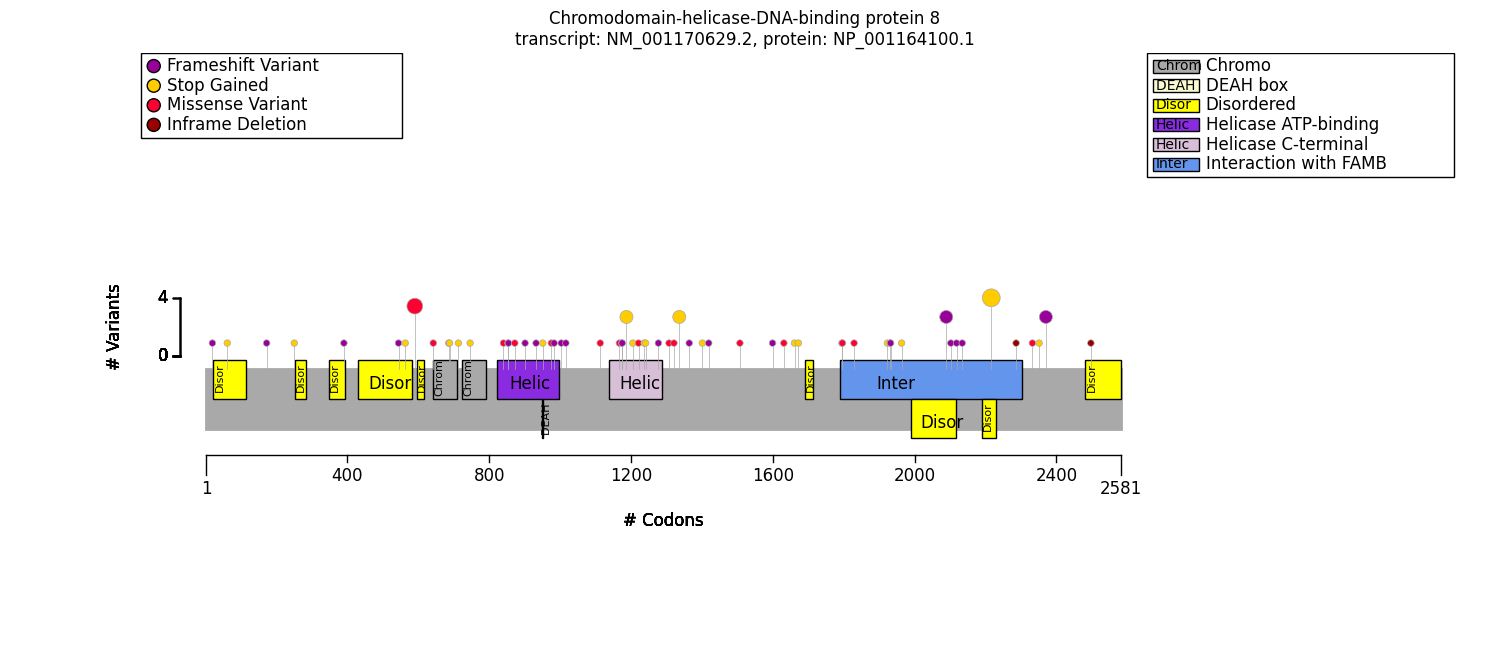

In [38]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

chd8_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
chd8_fig.tight_layout()

In [39]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,22 - 114,1,p.Ser62Ter
Disordered,REGION,253 - 283,0,
Disordered,REGION,349 - 392,1,p.Gln392ThrfsTer29
Disordered,REGION,429 - 582,2,p.Arg564Ter; p.Lys545AsnfsTer47
Disordered,REGION,596 - 615,0,
Chromo 1,DOMAIN,642 - 709,3,p.Ile643Ser; p.Glu689Ter; p.Gln687Glu
Chromo 2,DOMAIN,724 - 790,1,p.Tyr747Ter
Helicase ATP-binding,DOMAIN,823 - 997,9,p.Asn855LysfsTer30; p.Gly841Asp; p.Asp933ValfsTer2; p.Val984Ter; p.Asn873Asp; p.Tyr854Ter; p.Tyr902Ter; p.Arg952Ter; p.Thr976Lys
DEAH box,MOTIF,948 - 951,0,
Helicase C-terminal,DOMAIN,1137 - 1288,10,p.Leu1206Ter; p.Asp1278GlyfsTer2; p.Gln1238Ter; p.Asp1222Val; p.Arg1242Ter; p.Leu1175PhefsTer3; p.Tyr1168Asn; p.Arg1188Ter; p.Glu1177LysfsTer77


## Correlation Analysis

In [40]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [41]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_predicate = monoallelic_predicate(a_predicate=is_missense, 
                                     b_predicate=~is_missense, 
                                     a_label="Missense", 
                                     b_label="Not Missense")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)


In [42]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo, missense_result)

Allele group                                       Missense          \
                                                      Count Percent   
Autistic behavior [HP:0000729]                         8/14     57%   
Autism [HP:0000717]                                    4/12     33%   
Intellectual disability [HP:0001249]                   8/12     67%   
Tall stature [HP:0000098]                               2/7     29%   
Motor delay [HP:0001270]                                3/6     50%   
Pes planus [HP:0001763]                                 4/9     44%   
Delayed speech and language development [HP:000...      4/8     50%   
Short attention span [HP:0000736]                      3/12     25%   
Macrocephaly [HP:0000256]                               2/7     29%   
Hypertelorism [HP:0000316]                              2/7     29%   
Constipation [HP:0002019]                               4/8     50%   
Atypical behavior [HP:0000708]                          9/9    100%   
Neurodevelopmental abnormality [HP:0012759]           12/12    100%   
Abnormal axial skeleton morphology [HP:0009121]         3/3    100%   
Neurodevelopmental delay [HP:0012758]                   8/8    100%   
Prominent supraorbital ridges [HP:0000336]              4/6     67%   

Allele group                                       Not Missense          \
                                                          Count Percent   
Autistic behavior [HP:0000729]                            45/50     90%   
Autism [HP:0000717]                                       31/44     70%   
Intellectual disability [HP:0001249]                      47/53     89%   
Tall stature [HP:0000098]                                 21/32     66%   
Motor delay [HP:0001270]                                  26/32     81%   
Pes planus [HP:0001763]                                    5/30     17%   
Delayed speech and language development [HP:000...        22/28     79%   
Short attention span [HP:0000736]                         14/31     45%   
Macrocephaly [HP:0000256]                                 23/44     52%   
Hypertelorism [HP:0000316]                                15/32     47%   
Constipation [HP:0002019]                                 13/38     34%   
Atypical behavior [HP:0000708]                            49/49    100%   
Neurodevelopmental abnormality [HP:0012759]               57/57    100%   
Abnormal axial skeleton morphology [HP:0009121]           29/29    100%   
Neurodevelopmental delay [HP:0012758]                     30/30    100%   
Prominent supraorbital ridges [HP:0000336]                25/36     69%   

Allele group                                                           \
                                                   Corrected p values   
Autistic behavior [HP:0000729]                               0.155232   
Autism [HP:0000717]                                          0.320887   
Intellectual disability [HP:0001249]                         0.402026   
Tall stature [HP:0000098]                                    0.402026   
Motor delay [HP:0001270]                                     0.410033   
Pes planus [HP:0001763]                                      0.410033   
Delayed speech and language development [HP:000...           0.410033   
Short attention span [HP:0000736]                            0.612917   
Macrocephaly [HP:0000256]                                    0.644271   
Hypertelorism [HP:0000316]                                   0.644271   
Constipation [HP:0002019]                                    0.644271   
Atypical behavior [HP:0000708]                               1.000000   
Neurodevelopmental abnormality [HP:0012759]                  1.000000   
Abnormal axial skeleton morphology [HP:0009121]              1.000000   
Neurodevelopmental delay [HP:0012758]                        1.000000   
Prominent supraorbital ridges [HP:0000336]                   1.000000   

Allele group                                           

In [ ]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Autism [HP:0000717]                                  7/19     37%  28/37   
Prominent supraorbital ridges [HP:0000336]           5/13     38%  24/29   
Autistic behavior [HP:0000729]                      12/18     67%  41/46   
Tall stature [HP:0000098]                             3/8     38%  20/31   
Intellectual disability, mild [HP:0001256]           9/22     41%  11/42   
Constipation [HP:0002019]                            7/14     50%  10/32   
Hypertelorism [HP:0000316]                           5/16     31%  12/23   
Delayed speech and language development [HP:000...   6/10     60%  20/26   
Anxiety [HP:0000739]                                  4/8     50%   8/24   
Intellectual disability [HP:0001249]                16/20     80%  39/45   
Macrocephaly [HP:0000256]                            5/13     38%  20/38   
Atypical behavior [HP:0000708]                      12/12    100%  46/46   
Neurodevelopmental abnormality [HP:0012759]         22/22    100%  47/47   
Abnormal axial skeleton morphology [HP:0009121]       8/8    100%  24/24   
Short attention span [HP:0000736]                    5/14     36%  12/29   
Motor delay [HP:0001270]                             9/12     75%  20/26   
Neurodevelopmental delay [HP:0012758]               12/12    100%  26/26   

Sex                                                                            \
                                                   Percent Corrected p values   
Autism [HP:0000717]                                    76%           0.079528   
Prominent supraorbital ridges [HP:0000336]             83%           0.079528   
Autistic behavior [HP:0000729]                         89%           0.340621   
Tall stature [HP:0000098]                              65%           0.789593   
Intellectual disability, mild [HP:0001256]             26%           0.789593   
Constipation [HP:0002019]                              31%           0.789593   
Hypertelorism [HP:0000316]                             52%           0.789593   
Delayed speech and language development [HP:000...     77%           0.808299   
Anxiety [HP:0000739]                                   33%           0.808299   
Intellectual disability [HP:0001249]                   87%           0.808299   
Macrocephaly [HP:0000256]                              53%           0.808299   
Atypical behavior [HP:0000708]                        100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Short attention span [HP:0000736]                      41%           1.000000   
Motor delay [HP:0001270]                               77%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   

Sex                                                           
                                                    p values  
Autism [HP:0000717]                                 0.008006  
Prominent supraorbital ridges [HP:0000336]          0.009356  
Autistic behavior [HP:0000729]                      0.060110  
Tall stature [HP:0000098]                           0.234878  
Intellectual disability, mild [HP:0001256]          0.264484  
Constipation [HP:0002019]                           0.321471  
Hypertelorism [HP:0000316]                          0.325127  
Delayed speech and language development [HP:000...  0.412879  
Anxiety [HP:0000739]                                0.432509  
Intellectual disability [HP:0001249]                0.482231  
Macrocephaly [HP:0000256]                           0.523017  
Atypical behavior [HP:0000708]                      1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Abnormal axial skeleton morphology [HP:0009121]     1.000000  
Short a

In [49]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer, PhenotypeScoreAnalysis
from gpsea.analysis.pscore.stats import MannWhitneyStatistic

dv_scorer = DeVriesPhenotypeScorer(hpo)
mw_stats = MannWhitneyStatistic()

score_analysis = PhenotypeScoreAnalysis(mw_stats)
score_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, missense_predicate, dv_scorer)
df = score_results.data
df.head()
mean_missense = df[df["genotype"] == 0]["phenotype"].mean()
mean_other = df[df["genotype"] == 1]["phenotype"].mean()
pval = score_results.pval
message = f"DeVries score: missense: mean = {mean_missense:.3f}, other, mean = {mean_other:.3f}; p-val= {pval:.3e}"
print(message)

DeVries score: missense: mean = 1.056, other, mean = 1.975; p-val= 8.599e-04


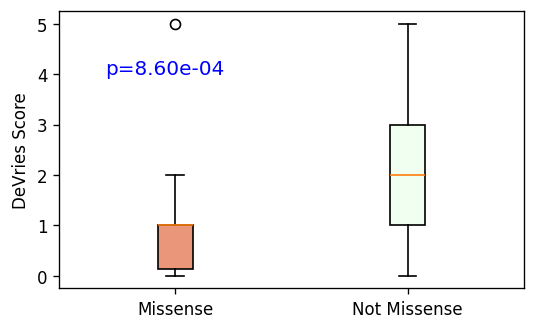

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
ax.set_ylabel("DeVries Score")
plt.text(0.7, 4, f'p={pval:.2e}', fontsize=12, color='blue')
score_results.plot_boxplots(ax=ax)

In [60]:
in_helicaseC = VariantPredicates.protein_feature("Helicase C-terminal", protein_metadata=protein_meta)
helicaseC_predicate = monoallelic_predicate(a_predicate=in_helicaseC, 
                                     b_predicate=~in_helicaseC, 
                                     a_label="Affects Helicase C", 
                                     b_label="Other")
result_heli = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=helicaseC_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, result_heli)

Allele group                                       Affects Helicase C          \
                                                                Count Percent   
Intellectual disability, moderate [HP:0002342]                    4/8     50%   
Abnormal movements of the upper extremities [HP...                2/4     50%   
Autism [HP:0000717]                                               6/7     86%   
Insomnia [HP:0100785]                                             2/3     67%   
Motor delay [HP:0001270]                                          5/5    100%   
Autistic behavior [HP:0000729]                                    8/8    100%   
Anxiety [HP:0000739]                                              3/5     60%   
Intellectual disability [HP:0001249]                              8/8    100%   
Prominent supraorbital ridges [HP:0000336]                        4/7     57%   
Macrocephaly [HP:0000256]                                         4/7     57%   
Atypical behavior [HP:0000708]                                    8/8    100%   
Neurodevelopmental abnormality [HP:0012759]                       8/8    100%   
Abnormal axial skeleton morphology [HP:0009121]                   5/5    100%   
Short attention span [HP:0000736]                                 1/3     33%   
Neurodevelopmental delay [HP:0012758]                             5/5    100%   
Delayed speech and language development [HP:000...                4/5     80%   
Tall stature [HP:0000098]                                         4/6     67%   
Hypertelorism [HP:0000316]                                        2/5     40%   

Allele group                                        Other          \
                                                    Count Percent   
Intellectual disability, moderate [HP:0002342]      10/55     18%   
Abnormal movements of the upper extremities [HP...   6/32     19%   
Autism [HP:0000717]                                 29/49     59%   
Insomnia [HP:0100785]                               12/38     32%   
Motor delay [HP:0001270]                            24/33     73%   
Autistic behavior [HP:0000729]                      45/56     80%   
Anxiety [HP:0000739]                                 9/27     33%   
Intellectual disability [HP:0001249]                47/57     82%   
Prominent supraorbital ridges [HP:0000336]          25/35     71%   
Macrocephaly [HP:0000256]                           21/44     48%   
Atypical behavior [HP:0000708]                      50/50    100%   
Neurodevelopmental abnormality [HP:0012759]         61/61    100%   
Abnormal axial skeleton morphology [HP:0009121]     27/27    100%   
Short attention span [HP:0000736]                   16/40     40%   
Neurodevelopmental delay [HP:0012758]               33/33    100%   
Delayed speech and language development [HP:000...  22/31     71%   
Tall stature [HP:0000098]                           19/33     58%   
Hypertelorism [HP:0000316]                          15/34     44%   

Allele group                                                           \
                                                   Corrected p values   
Intellectual disability, moderate [HP:0002342]               0.763867   
Abnormal movements of the upper extremities [HP...           0.763867   
Autism [HP:0000717]                                          0.763867   
Insomnia [HP:0100785]                                        0.763867   
Motor delay [HP:0001270]                                     0.763867   
Autistic behavior [HP:0000729]                               0.763867   
Anxiety [HP:0000739]                                         0.763867   
Intellectual disability [HP:0001249]                         0.763867   
Prominent supraorbital ridges [HP:0000336]                   1.000000   
Macrocephaly [HP:0000256]                                    1.000000   
Atypical behavior [HP:0000708]                               1.000000   
Neurodevelopmental abnormality [HP:0012759]      

In [64]:
score_analysis = PhenotypeScoreAnalysis(mw_stats)
score_results_heli = score_analysis.compare_genotype_vs_phenotype_score(cohort, helicaseC_predicate, dv_scorer)
df = score_results_heli.data
df.head()
mean_heli = df[df["genotype"] == 0]["phenotype"].mean()
mean_other = df[df["genotype"] == 1]["phenotype"].mean()
pval = score_results_heli.pval
message = f"DeVries score: missense: mean = {mean_heli:.3f}, other, mean = {mean_other:.3f}; p-val= {pval:.3e}"
print(message)

DeVries score: missense: mean = 2.200, other, mean = 1.703; p-val= 3.648e-01
